<a href="https://colab.research.google.com/github/DataScience-Challenge-Group1/Data-Science-Challenge-Hackathon/blob/main/notebooks/hackathon__5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training shape: (4756, 31)
Testing shape: (4749, 30)
seasonal_vaccine
1    0.536375
0    0.463625
Name: proportion, dtype: float64


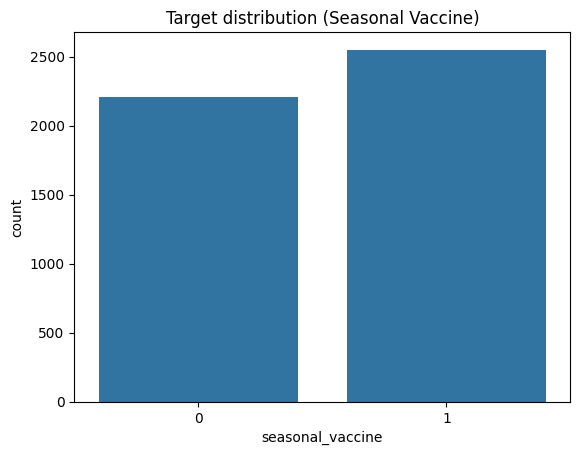

[LightGBM] [Info] Number of positive: 2040, number of negative: 1764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 940
[LightGBM] [Info] Number of data points in the train set: 3804, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536278 -> initscore=0.145366
[LightGBM] [Info] Start training from score 0.145366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
# === Part 1 : MICE Imputation + Supervised Model (LightGBM) ===

# Install required libraries
!pip install lightgbm shap pdpbox --quiet

# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load datasets ---
train = pd.read_csv("/content/drive/MyDrive/Hackathon/dataset_A_training.csv")
test  = pd.read_csv("/content/drive/MyDrive/Hackathon/dataset_A_testing.csv")


TARGET = 'seasonal_vaccine'
ID_COL = 'respondent_id'

print("Training shape:", train.shape)
print("Testing shape:", test.shape)

# --- Basic EDA ---
print(train[TARGET].value_counts(normalize=True))
sns.countplot(x=TARGET, data=train)
plt.title("Target distribution (Seasonal Vaccine)")
plt.show()

# --- Separate features/target ---
X = train.drop(columns=[TARGET, ID_COL])
y = train[TARGET]

# --- Identify categorical and numerical columns ---
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# --- Step 1: Preprocessing pipeline (One-Hot Encode categorical, then MICE impute numerical) ---
# Create a pipeline for preprocessing
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols) # Pass numerical columns through for now
])

# Apply one-hot encoding
X_processed = preprocess.fit_transform(X)
X_processed = pd.DataFrame(X_processed) # Convert back to DataFrame

# --- Step 2: MICE imputation (BayesianRidge) on numerical columns ---
# Need to re-identify numerical columns after one-hot encoding
num_cols_processed = X_processed.select_dtypes(include=np.number).columns

mice_imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
X_imputed = mice_imp.fit_transform(X_processed[num_cols_processed])
X_imputed = pd.DataFrame(X_imputed, columns=num_cols_processed)

# Combine imputed numerical columns with one-hot encoded categorical columns
# We need to re-apply one-hot encoding to get the correct column names after imputation
preprocess_final = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42), num_cols)
])

# Apply the final preprocessing including imputation
X_final = preprocess_final.fit_transform(X)
X_final = pd.DataFrame(X_final) # Convert back to DataFrame


# --- Step 3: Split train/validation ---
# Use X_final for splitting
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# --- Step 4: Train LightGBM model ---
# The preprocessing is now done before splitting, so the pipeline only needs the classifier
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(X_train, y_train)

# --- Step 5: Evaluate on validation set ---
y_pred = lgbm.predict(X_val)
y_prob = lgbm.predict_proba(X_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_prob))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

# --- Step 6: Predict on test set ---
# Apply the same preprocessing to the test set
test_processed = preprocess_final.transform(test.drop(columns=[ID_COL], errors='ignore'))
test_processed = pd.DataFrame(test_processed) # Convert back to DataFrame

y_test_pred = lgbm.predict_proba(test_processed)[:, 1]

submission = pd.DataFrame({ID_COL: test[ID_COL], TARGET: y_test_pred})
submission.to_csv('LGBM_MICE_submission.csv', index=False)
print("✅ Saved LGBM_MICE_submission.csv")